# Introduction

In this notebook, we shift from raw binary classification to a more nuanced and clinically relevant approach, predicting the risk of developing Alzheimer's disease as calibrated probabilities.

We use our best-performing tuned AdaBoost classifier for the full dataset and calibrate the outputs. Calibration adjusts the model's raw confidence scores so they better reflect the true likelihood of a diagnosis.

We start with isotonic regression, a flexible, non-parametric calibration method suited for large datasets. Then, we compare it with Platt scaling (sigmoid calibration), a parametric approach that fits a logistic curve, often more stable when data is limited.

By comparing both methods, we can determine which provides the most reliable probabilistic outputs for assessing Alzheimer’s risk.

Finally, we go a step further and map the resulting calibrated probabilities into clinically interpretable risk categories — such as Low, Medium, and High risk.

In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style

set_style("whitegrid")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, RocCurveDisplay

## Loading the data

In [28]:
## Reading the traning and testing datasets
df_train = pd.read_csv("../../data/train_set.csv")
df_test = pd.read_csv("../../data/validation_set.csv")

## Dropping redundant columns
df_train = df_train.drop(columns = ['DoctorInCharge' , 'PatientID' ])
df_test = df_test.drop(columns = ['DoctorInCharge' , 'PatientID' ])

df_train.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,67,0,1,2,29.726811,1,15.642599,4.605988,7.871526,7.915239,...,6.088453,1,0,9.105791,0,0,0,0,0,0
1,76,1,1,2,36.169103,1,11.030414,9.534553,7.254090,4.364895,...,5.399515,1,0,4.725688,0,0,0,0,1,1
2,81,0,1,0,22.923111,0,9.314832,8.917378,3.807813,9.241849,...,4.594907,0,1,8.681801,0,0,0,0,0,1
3,90,0,1,3,31.430904,0,0.996496,7.108725,5.328610,4.977538,...,0.880355,0,0,7.805410,0,0,0,0,0,0
4,89,0,1,3,39.570099,0,1.576700,5.712014,1.026138,4.670244,...,0.293490,0,0,1.307295,0,0,0,0,1,1


In [30]:
## Seperating features into subcategories

all_features = ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI',
               'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality',
               'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease',
               'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP',
               'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL',
               'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment',
               'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion',
               'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks',
               'Forgetfulness' , 'Diagnosis']
demo_features = ['Age', 'Gender', 'Ethnicity','EducationLevel','Diagnosis']
life_style_features = ['BMI','Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality','Diagnosis']
medic_hist_features = ['FamilyHistoryAlzheimers', 'CardiovascularDisease','Diabetes', 'Depression', 'HeadInjury', 'Hypertension','Diagnosis']
clinical_features = ['SystolicBP','DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL','CholesterolTriglycerides','Diagnosis']
cognitive_features = ['MMSE', 'FunctionalAssessment','MemoryComplaints', 'BehavioralProblems', 'ADL','Diagnosis']
symptoms_features = ['Confusion','Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks','Forgetfulness','Diagnosis']

no_cognitive = [item for item in all_features if item not in cognitive_features]
no_cognitive.append('Diagnosis')

subcategory_dict = {'all_features' : all_features,'demo':demo_features ,'lifestyle': life_style_features , 'medic' : medic_hist_features , 
                    'clinical':clinical_features , 'cognitive': cognitive_features , 'symptoms': symptoms_features , 'no_cognitive': no_cognitive}

## The tuned AdaBoost model

Here, we use the manually recorded tuned parameters from our notebook [Model_Tuning_Entire_Set](https://github.com/mgamankwah/alzheimers_risk_prediction/blob/main/scripts/3-Model%20Tuning/1_Model_Tuning_Entire_Set_Seyed.ipynb).

In [32]:
# Best params from tuning
model_tuned_tree_params = {
    'criterion': 'entropy',
    'max_depth': 2,
    'min_samples_split': 19
}
model_tuned_ada_params = {
    'n_estimators': 130,
    'learning_rate': 0.26971280658002783,
    'algorithm': 'SAMME.R'
}

# Tuned AdaBoost model for the entire dataset
model_tuned_entire_dataset = AdaBoostClassifier(
    **model_tuned_ada_params,
    estimator=DecisionTreeClassifier(**model_tuned_tree_params, random_state=123),
    random_state=123
)

model_tuned_entire_dataset.fit(df_train[all_features[:-1]], df_train.Diagnosis)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=2,
                                                    min_samples_split=19,
                                                    random_state=123),
                   learning_rate=0.26971280658002783, n_estimators=130,
                   random_state=123)

# Raw Probabilities (Uncalibrated)

Before applying calibration techniques, we examined the raw probability outputs of the uncalibrated AdaBoost model. This helps assess how well the model’s original predicted probabilities align with actual outcome frequencies.

In [34]:
# Predict raw probabilities on the test set from the uncalibrated AdaBoost model
uncalibrated_probs = model_tuned_entire_dataset.predict_proba(df_test[all_features[:-1]])[:, 1]

# Add to test dataframe for inspection
df_test['uncalibrated_risk'] = uncalibrated_probs
df_test[['Diagnosis', 'uncalibrated_risk']].head()

,Diagnosis,uncalibrated_risk
0,0,0.471845
1,1,0.507103
2,1,0.512039
3,0,0.408239
4,0,0.466923


Next, we compare the uncalibrated probabilities with the ideally calibrated model (i.e., predicted probability = actual probability).

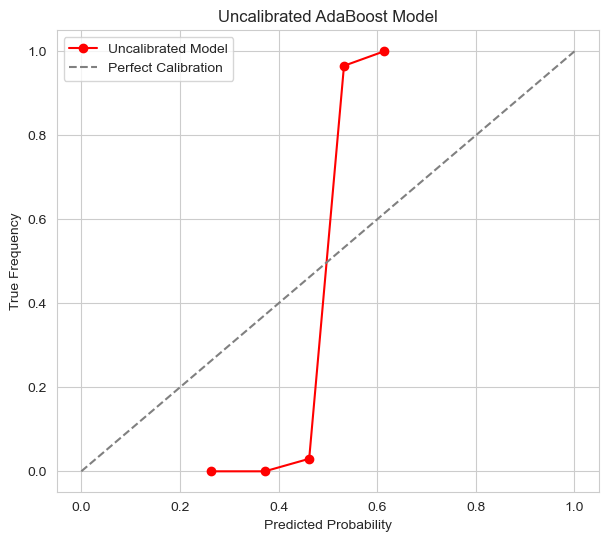

In [36]:
# Generate calibration curve values for uncalibrated model
true_uncal, pred_uncal = calibration_curve(df_test.Diagnosis, df_test['uncalibrated_risk'], n_bins=10)

# Plot calibration curve
plt.figure(figsize=(7, 6))
plt.plot(pred_uncal, true_uncal, marker='o', color='red', label='Uncalibrated Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Frequency')
plt.title('Uncalibrated AdaBoost Model')
plt.legend()
plt.grid(True)
plt.show()

# Calibrated Probabilities

We use isotonic and sigmoid calibration pipelines and compare them.

## Isotonic Calibration Pipeline

In [38]:
calibrated_model_isotonic = CalibratedClassifierCV(estimator=model_tuned_entire_dataset, method='isotonic', cv=5)
calibrated_model_isotonic.fit(df_train[all_features[:-1]], df_train.Diagnosis)

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123),
                       method='isotonic')

In [40]:
# Predict calibrated probabilities on the test set
calibrated_probs_isotonic = calibrated_model_isotonic.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk_iso'] = calibrated_probs_isotonic
df_test[['Diagnosis', 'alzheimers_risk_iso']].head()

,Diagnosis,alzheimers_risk_iso
0,0,0.066837
1,1,0.711071
2,1,0.884134
3,0,0.035592
4,0,0.120600


## Sigmoid Calibration Pipeline (Platt Scaling)

In [42]:
calibrated_model_sigmoid = CalibratedClassifierCV(estimator=model_tuned_entire_dataset, method='sigmoid', cv=5)
calibrated_model_sigmoid.fit(df_train[all_features[:-1]], df_train.Diagnosis)

CalibratedClassifierCV(cv=5,
                       estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                     max_depth=2,
                                                                                     min_samples_split=19,
                                                                                     random_state=123),
                                                    learning_rate=0.26971280658002783,
                                                    n_estimators=130,
                                                    random_state=123))

In [44]:
# Predict calibrated probabilities on the test set
calibrated_probs_sigmoid = calibrated_model_sigmoid.predict_proba(df_test[all_features[:-1]])[:, 1]  # Probability of class 1 (Alzheimer’s)

# Add to test dataframe for inspection
df_test['alzheimers_risk_sig'] = calibrated_probs_sigmoid
df_test[['Diagnosis', 'alzheimers_risk_sig']].head()

,Diagnosis,alzheimers_risk_sig
0,0,0.189849
1,1,0.565853
2,1,0.675354
3,0,0.006624
4,0,0.206460


# Comaprison of Calibrated Models

In this section, we compare the isotonic vs sigmoid calibrations on the basis of Brier scores and ROC-AUC.

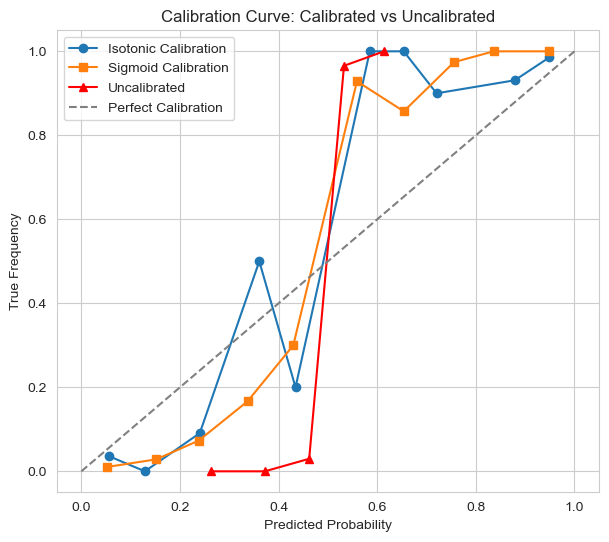

Brier Score (Isotonic):     0.0439
Brier Score (Sigmoid):      0.0618
Brier Score (Uncalibrated): 0.2105
ROC AUC Score (Isotonic):     0.9705
ROC AUC Score (Sigmoid):      0.9761
ROC AUC Score (Uncalibrated): 0.9761


In [46]:
# Calibration curve values
true_iso, pred_iso = calibration_curve(df_test.Diagnosis, calibrated_probs_isotonic, n_bins=10)
true_sigmoid, pred_sigmoid = calibration_curve(df_test.Diagnosis, calibrated_probs_sigmoid, n_bins=10)
true_uncal, pred_uncal = calibration_curve(df_test.Diagnosis, df_test['uncalibrated_risk'], n_bins=10)

# Plot all curves
plt.figure(figsize=(7, 6))
plt.plot(pred_iso, true_iso, marker='o', label='Isotonic Calibration')
plt.plot(pred_sigmoid, true_sigmoid, marker='s', label='Sigmoid Calibration')
plt.plot(pred_uncal, true_uncal, marker='^', color='red', label='Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')

plt.xlabel('Predicted Probability')
plt.ylabel('True Frequency')
plt.title('Calibration Curve: Calibrated vs Uncalibrated')
plt.legend()
plt.grid(True)
plt.show()

# Brier Scores (lower is better)
brier_iso = brier_score_loss(df_test.Diagnosis, calibrated_probs_isotonic)
brier_sigmoid = brier_score_loss(df_test.Diagnosis, calibrated_probs_sigmoid)
brier_uncal = brier_score_loss(df_test.Diagnosis, df_test['uncalibrated_risk'])

print(f"Brier Score (Isotonic):     {brier_iso:.4f}")
print(f"Brier Score (Sigmoid):      {brier_sigmoid:.4f}")
print(f"Brier Score (Uncalibrated): {brier_uncal:.4f}")

# ROC AUC Scores (higher is better)
roc_auc_iso = roc_auc_score(df_test.Diagnosis, calibrated_probs_isotonic)
roc_auc_sigmoid = roc_auc_score(df_test.Diagnosis, calibrated_probs_sigmoid)
roc_auc_uncal = roc_auc_score(df_test.Diagnosis, df_test['uncalibrated_risk'])

print(f"ROC AUC Score (Isotonic):     {roc_auc_iso:.4f}")
print(f"ROC AUC Score (Sigmoid):      {roc_auc_sigmoid:.4f}")
print(f"ROC AUC Score (Uncalibrated): {roc_auc_uncal:.4f}")

# Categorizing patients into Low/Medium/High risk groups

We now define risk buckets to categorize patients into low/mediun/high risk groups. Here is a proposed thresholding scheme:

- Low Risk: risk probability < 0.33
- Medium Risk: 0.33 ≤ risk probability < 0.66
- High Risk: risk probability ≥ 0.66

We may adjust these cutoffs depending on how aggressive or conservative we want to be.

In [50]:
def assign_risk_group(prob):
    if prob < 0.33:
        return 'Low'
    elif prob < 0.66:
        return 'Medium'
    else:
        return 'High'

## Confusion Matrix for Uncalibrated Probabilities

In [72]:
# Apply to the test set
df_test['risk_group'] = df_test['uncalibrated_risk'].apply(assign_risk_group)
df_test[['Diagnosis', 'uncalibrated_risk', 'risk_group']].head()

,Diagnosis,uncalibrated_risk,risk_group
0,0,0.471845,Medium
1,1,0.507103,Medium
2,1,0.512039,Medium
3,0,0.408239,Medium
4,0,0.466923,Medium


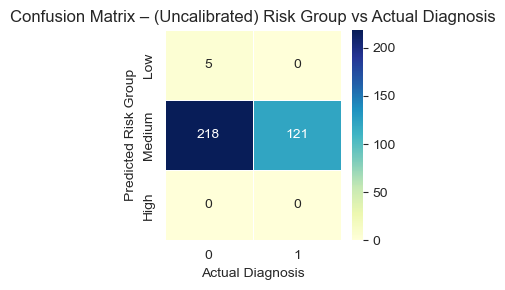

In [74]:
# Ensure risk_group is a categorical variable with proper ordering
df_test['risk_group'] = pd.Categorical(
    df_test['risk_group'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Compute crosstab with correct row order
risk_matrix = pd.crosstab(
    df_test['risk_group'],
    df_test['Diagnosis'],
    rownames=['Predicted Risk Group'],
    colnames=['Actual Diagnosis'],
    dropna=False
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(3, 3)) 
sns.heatmap(risk_matrix, annot=True, fmt='d', cmap='YlGnBu',
            ax=ax, linewidths=0.5, linecolor='white')
ax.set_title("Confusion Matrix – (Uncalibrated) Risk Group vs Actual Diagnosis")
ax.set_xlabel("Actual Diagnosis")
ax.set_ylabel("Predicted Risk Group")

plt.tight_layout()
plt.show()

## Confusion Matrix for Isotonic-Calibrated Probabilities

In [60]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk_iso'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk_iso', 'risk_group']].head()

,Diagnosis,alzheimers_risk_iso,risk_group
0,0,0.066837,Low
1,1,0.711071,High
2,1,0.884134,High
3,0,0.035592,Low
4,0,0.120600,Low


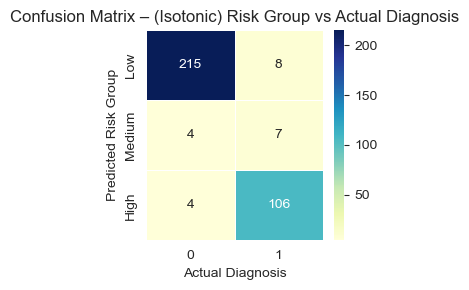

In [62]:
# Ensure risk_group is a categorical variable with proper ordering
df_test['risk_group'] = pd.Categorical(
    df_test['risk_group'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Compute crosstab with correct row order
risk_matrix = pd.crosstab(
    df_test['risk_group'],
    df_test['Diagnosis'],
    rownames=['Predicted Risk Group'],
    colnames=['Actual Diagnosis']
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(3, 3)) 
sns.heatmap(risk_matrix, annot=True, fmt='d', cmap='YlGnBu',
            ax=ax, linewidths=0.5, linecolor='white')
ax.set_title("Confusion Matrix – (Isotonic) Risk Group vs Actual Diagnosis")
ax.set_xlabel("Actual Diagnosis")
ax.set_ylabel("Predicted Risk Group")

plt.tight_layout()
plt.show()

## Confusion Matrix for Sigmoid-Calibrated Probabilities

In [77]:
# Apply to the test set
df_test['risk_group'] = df_test['alzheimers_risk_sig'].apply(assign_risk_group)
df_test[['Diagnosis', 'alzheimers_risk_sig', 'risk_group']].head()

,Diagnosis,alzheimers_risk_sig,risk_group
0,0,0.189849,Low
1,1,0.565853,Medium
2,1,0.675354,High
3,0,0.006624,Low
4,0,0.206460,Low


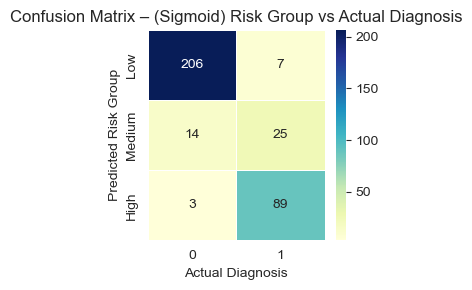

In [79]:
# Ensure risk_group is a categorical variable with proper ordering
df_test['risk_group'] = pd.Categorical(
    df_test['risk_group'],
    categories=['Low', 'Medium', 'High'],
    ordered=True
)

# Compute crosstab with correct row order
risk_matrix = pd.crosstab(
    df_test['risk_group'],
    df_test['Diagnosis'],
    rownames=['Predicted Risk Group'],
    colnames=['Actual Diagnosis']
)

# Plot heatmap
fig, ax = plt.subplots(figsize=(3, 3)) 
sns.heatmap(risk_matrix, annot=True, fmt='d', cmap='YlGnBu',
            ax=ax, linewidths=0.5, linecolor='white')
ax.set_title("Confusion Matrix – (Sigmoid) Risk Group vs Actual Diagnosis")
ax.set_xlabel("Actual Diagnosis")
ax.set_ylabel("Predicted Risk Group")

plt.tight_layout()
plt.show()

# Conclusion

- Our uncalibrated model ranks most patients as 'Medium' risk, and failed to identify even a single Alzheimer's patient as 'High' risk.
- Isotonic calibration fixed that without hurting discrimination.
- Isotonic increased the number of correct classifications of Alzheimer's patients as 'High' risk from 0 to 106, as opposed to sigmoid with only 89.